### Libraries and functions

In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from vtk_rw import read_vtk
from plotting import plot_surf_stat_map, crop_img
import matplotlib as mpl
import networkx as nx
from graphs import graph_from_mesh
#from SurfacePlotting import PlotSurfaces

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def load_pickle(pkl_file):
    pkl_in = open(pkl_file, 'r')
    pkl_dict = pickle.load(pkl_in)
    pkl_in.close()
    return pkl_dict

In [4]:
def brain_fig(plot_list):
    sns.set_style('white')
    n = len(plot_list)
    rows = int(n/4)
    fig = plt.figure(figsize=(40,rows*5))
    for img in range(n):
        ax = fig.add_subplot(rows,4,img+1)
        plt.imshow(plot_list[img])
        ax.set_axis_off()
    fig.tight_layout()
    fig.subplots_adjust(right=0.7)
    return fig

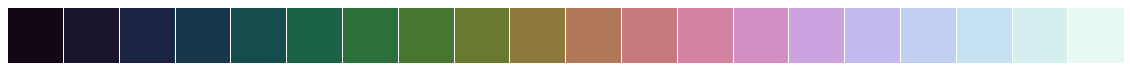

In [5]:
colors = sns.color_palette('cubehelix', 20)
sns.palplot(colors)
pic_folder = '/scr/ilz3/myelinconnect/new_groupavg/pics/manuscript/'

### Load meshes for visualization

In [6]:
lh_mesh_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_infl1000.vtk'
lh_sulc_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/lh_sulc.npy'
rh_mesh_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_infl1000.vtk'
rh_sulc_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/rh_sulc.npy'
fullmask_file = '/scr/ilz3/myelinconnect/new_groupavg/masks/fullmask_lh_rh_new.npy'
lh_sulc = np.load(lh_sulc_file)
lv, lf, _ = read_vtk(lh_mesh_file)
rh_sulc = np.load(rh_sulc_file)
rv, rf, _ = read_vtk(rh_mesh_file)
fullmask = np.load(fullmask_file)

### Load and prep embeddings

In [7]:
embed_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed.npy'
dict_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed_dict.pkl'

In [8]:
embed_dict = load_pickle(dict_file)
eigenval=embed_dict['lambdas']
perc_var = eigenval/np.sum(eigenval)*100
#orig_eigenval=embed_dict['orig_lambdas'][1:]
#orig_perc_var = orig_eigenval/np.sum(orig_eigenval)*100

In [9]:
# normalize vectors
embed_masked = np.zeros((embed_dict['vectors'].shape[0], embed_dict['vectors'].shape[1]-1))
for comp in range(100):
    embed_masked[:,comp]=(embed_dict['vectors'][:,comp+1]/embed_dict['vectors'][:,0])

# unmask the embedding, that has been saved in masked form
idcs=np.arange(0,(lv.shape[0]+rv.shape[0]))
nonmask=np.delete(idcs, fullmask)
embed = np.zeros(((lv.shape[0]+rv.shape[0]),100))
embed[nonmask] = embed_masked

### Load models

In [10]:
t1_predict_file_0 = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/both_t1avg_by_fc_maps_0.pkl'
t1_predict_file_best = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/both_t1avg_by_fc_maps_best.pkl'
t1_predict_file_all = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/both_t1avg_by_fc_maps_all.pkl'
t1_predict_file_04 = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/both_t1avg_by_fc_maps_0_4.pkl'
t1_predict_file_05 = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/both_t1avg_by_fc_maps_0_5.pkl'
t1_predict_0 = load_pickle(t1_predict_file_0)
t1_predict_best = load_pickle(t1_predict_file_best)
t1_predict_all = load_pickle(t1_predict_file_all)
t1_predict_04 = load_pickle(t1_predict_file_04)
t1_predict_05 = load_pickle(t1_predict_file_05)

## Figure 1

In [108]:
sns.set_style('white')
plots_fig1 = []
vmin = 1700 
vmax = 2300 
embed_vmin=-2.2
embed_vmax=2.4
for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(lv, lf, stat_map=t1_predict_0['t1'][:lv.shape[0]], bg_map=lh_sulc, 
                            bg_on_stat=False, darkness=0.8, elev=elev,azim=azim, figsize=(10,7.5) ,
                            threshold=1700, cmap='cubehelix_r', vmin=vmin, vmax = vmax, symmetric_cbar=False)
    plots_fig1.append(crop_img(plot))

for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(rv, rf, stat_map=t1_predict_0['t1'][lv.shape[0]:], bg_map=rh_sulc, 
                            bg_on_stat=False, darkness=0.8, elev=elev,azim=azim, figsize=(10,7.7) ,
                            threshold=1700, cmap='cubehelix_r', vmin=vmin, vmax=vmax,symmetric_cbar=False)
    plots_fig1.append(crop_img(plot))

for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(lv, lf, stat_map=-embed[:lv.shape[0],0], bg_map=lh_sulc, 
                            bg_on_stat=False, darkness=0.8, elev=elev,azim=azim, figsize=(10,7.5), 
                            threshold=1e-50, cmap='cubehelix_r', symmetric_cbar=False,
                           vmin=embed_vmin, vmax=embed_vmax)
    plots_fig1.append(crop_img(plot))

for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(rv, rf, stat_map=-embed[lv.shape[0]:,0], bg_map=rh_sulc, 
                            bg_on_stat=False, darkness=0.8, elev=elev,azim=azim, figsize=(10,7.7) ,
                            threshold=1e-50, cmap='cubehelix_r',symmetric_cbar=False, 
                           vmin=embed_vmin, vmax=embed_vmax)
    plots_fig1.append(crop_img(plot))

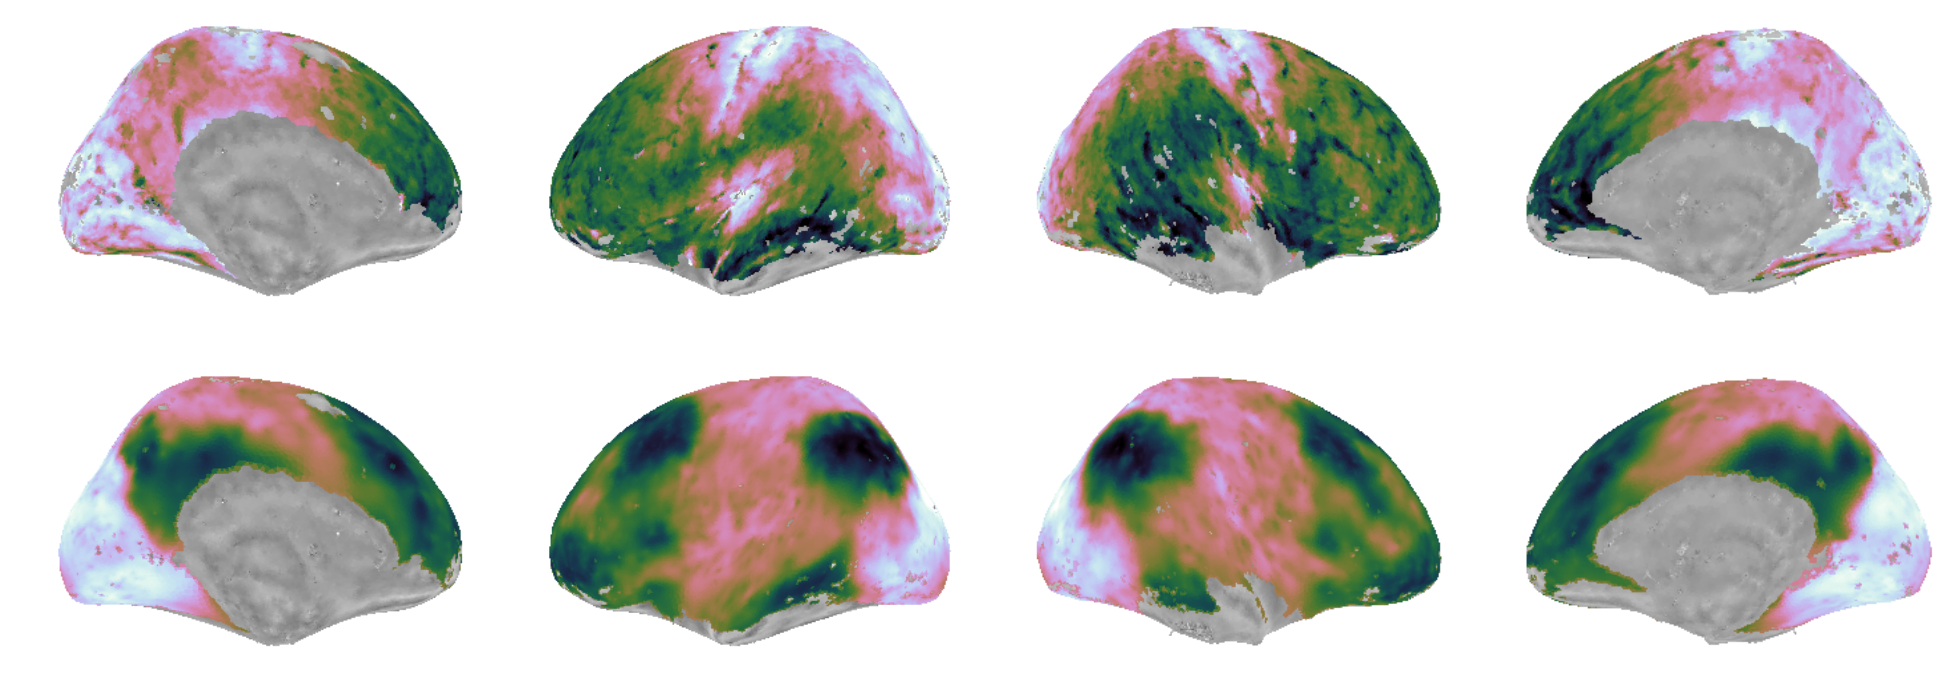

In [109]:
fig = brain_fig(plots_fig1)

In [110]:
fig.savefig(pic_folder+'fig1_brains.png')

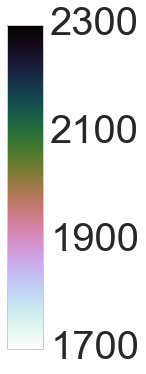

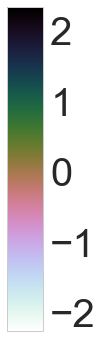

In [164]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=4)
cubehelix = plt.get_cmap('cubehelix_r')
norm_t1 = mpl.colors.Normalize(vmin=1700, vmax=2300)
norm_embed = mpl.colors.Normalize(vmin=embed_vmin, vmax=embed_vmax)
#fig_hcbar = plt.figure(figsize=(10, 3))
#ax1 = fig_hcbar.add_axes([0.05, 0.80, 0.9, 0.15])
#mpl.colorbar.ColorbarBase(ax1, cmap=cubehelix,norm=norm_t1,orientation='horizontal', ticks=[1700, 1900, 2100, 2300])

fig_vcbar = plt.figure(figsize=(10, 5))
ax1 = fig_vcbar.add_axes([0.05, 0.05, 0.05, 0.9])
mpl.colorbar.ColorbarBase(ax1, cmap=inferno,norm=norm_t1,orientation='vertical', ticks=[1700, 1900, 2100, 2300])

#fig_hcbar.savefig(pic_folder+'fig1_myelinbar.svg')
fig_vcbar.savefig(pic_folder+'fig1_myelinbar_vert.svg')

#fig_hcbar = plt.figure(figsize=(10, 3))
#ax1 = fig_hcbar.add_axes([0.05, 0.80, 0.9, 0.15])
#mpl.colorbar.ColorbarBase(ax1, cmap=cubehelix,norm=norm_embed,orientation='horizontal', ticks=[-2, -1, 0, 1, 2])

fig_vcbar = plt.figure(figsize=(10, 5))
ax1 = fig_vcbar.add_axes([0.05, 0.05, 0.05, 0.9])
mpl.colorbar.ColorbarBase(ax1, cmap=inferno,norm=norm_embed,orientation='vertical', ticks=[-2, -1, 0, 1, 2])


#fig_hcbar.savefig(pic_folder+'fig1_embedbar.svg')
fig_vcbar.savefig(pic_folder+'fig1_embedbar_vert.svg')


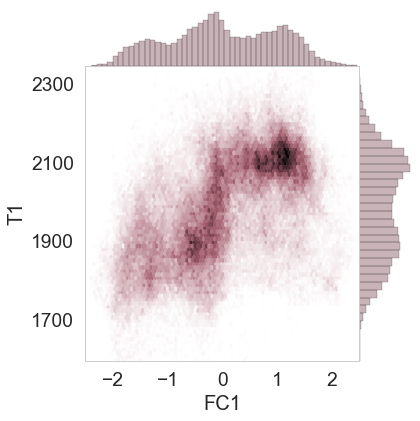

In [19]:
sns.set_style('whitegrid',{'axes.grid': False})
sns.set_context('poster', font_scale=1.2)
scatter_mask = np.where(t1_predict_0['t1']>1500)

xlim = (-2.5, 2.5)
ylim = (1600, 2350)
yticks = [1700, 1900,2100, 2300]
scatter_color = sns.xkcd_rgb['brownish purple']
fig = sns.jointplot(-embed[:,0][scatter_mask], 
                    t1_predict_0['t1'][scatter_mask],
                    stat_func=None,space=0,ylim=ylim,xlim=xlim,
                    kind="hex", size=6, color=scatter_color)
fig.set_axis_labels('FC1', 'T1', fontsize=20)
fig.ax_joint.set_yticks(yticks);
fig.savefig(pic_folder+'fig1_scatter.png')

## Figure 2

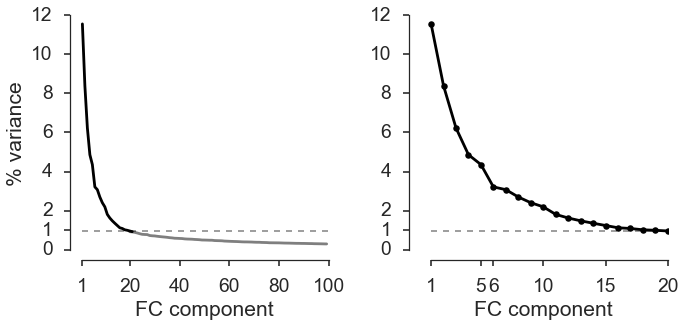

In [21]:
sns.set_context('poster', font_scale=1.2)
sns.set_style("ticks")
fig=plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
plt.plot(np.arange(1,22),perc_var[:21], color='black')
plt.plot(np.arange(20,100), perc_var[20:], color='black', alpha=.5)
ax1.hlines(.95, 1, 100, linestyle='--', linewidth=1.5, colors='black',alpha=0.5)
plt.ylabel('% variance')
plt.xlabel('FC component')
plt.yticks([0,1,2,4,6,8,10,12])
plt.xticks([1,20,40,60,80,100])

ax2 = fig.add_subplot(122)
plt.plot(np.arange(1,21), perc_var[:20], color='black', marker='.', markersize=13)
ax2.hlines(.95, 1, 20, linestyle='--', linewidth=1.5, colors='black',alpha=0.5)
plt.xlabel('FC component')
plt.xticks([1,5,6, 10,15,20])
plt.yticks([0,1,2,4,6,8,10,12])
sns.despine(offset=10, trim=True)
fig.tight_layout()
fig.savefig(pic_folder+'fig2_components.svg')

In [22]:
print perc_var[0], perc_var[4], perc_var[5]

11.558796297 4.35374764593 3.21126524426


In [23]:
cropped_embed = []
sns.set_style('white')
for comp in [0,4,5]:
    
    for (elev, azim) in [(180, 0), (180, 180)]:
        plot=plot_surf_stat_map(lv, lf, stat_map=-embed[:lv.shape[0],comp], bg_map=lh_sulc, bg_on_stat=False, 
                                darkness=0.8, elev=elev,azim=azim, figsize=(10,7.5) ,
                                threshold=1e-50, cmap='cubehelix_r',symmetric_cbar='auto')
        cropped_embed.append(crop_img(plot))

    for (elev, azim) in [(180, 0), (180, 180)]:
        plot=plot_surf_stat_map(rv, rf, stat_map=-embed[lv.shape[0]:,comp], bg_map=rh_sulc, bg_on_stat=False, 
                                darkness=0.8, elev=elev,azim=azim, figsize=(10,7.7) ,
                                threshold=1e-50, cmap='cubehelix_r',symmetric_cbar='auto')
        cropped_embed.append(crop_img(plot))

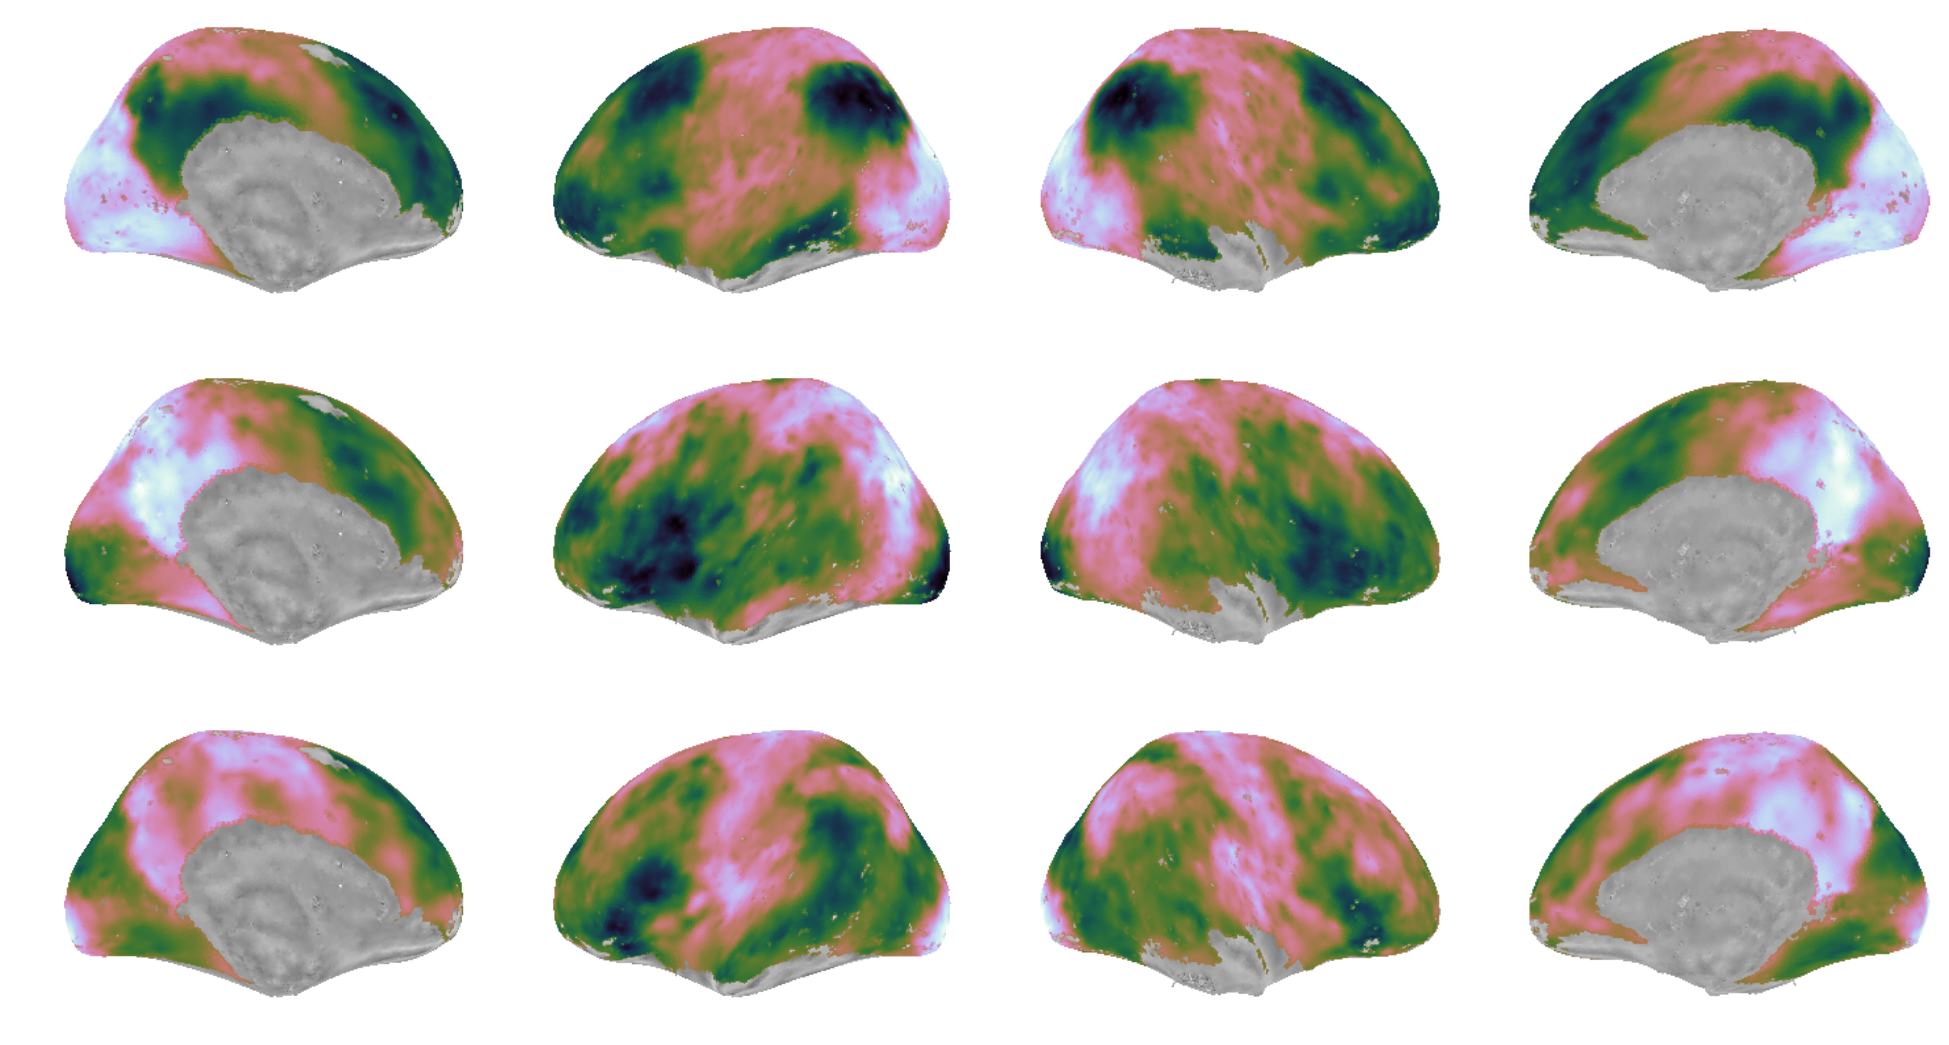

In [24]:
fig = brain_fig(cropped_embed)
fig.savefig(pic_folder+'fig2_brains.png')

In [25]:
model_df = pd.read_csv('/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/model_comparison_20maps.csv')
#model_df.iloc[np.argmin(model_df["BIC"])]

len_maps = [len(eval(model_df['maps'][i])) for i in range(len(model_df['maps']))]
map_transitions = np.asarray([x for x in range(len(len_maps)-1) if len_maps[x]!=len_maps[x+1]])
#map_transitions = map_transitions[:-1]

zero_patches = []
patches = []
model_start = 0
for trans in map_transitions:
    model_end = int(trans)+1
    patches.append(range(model_start, model_end))
    zero_patch = [i for i in range(model_start, model_end) if '(0' in model_df['maps'][i]]
    zero_patches.append([zero_patch[0], zero_patch[-1]-zero_patch[0]])
    model_start = model_end  
patches.append([map_transitions[-1]+1])
zero_patches[0][0] = -2
zero_patches[0][1] = 2

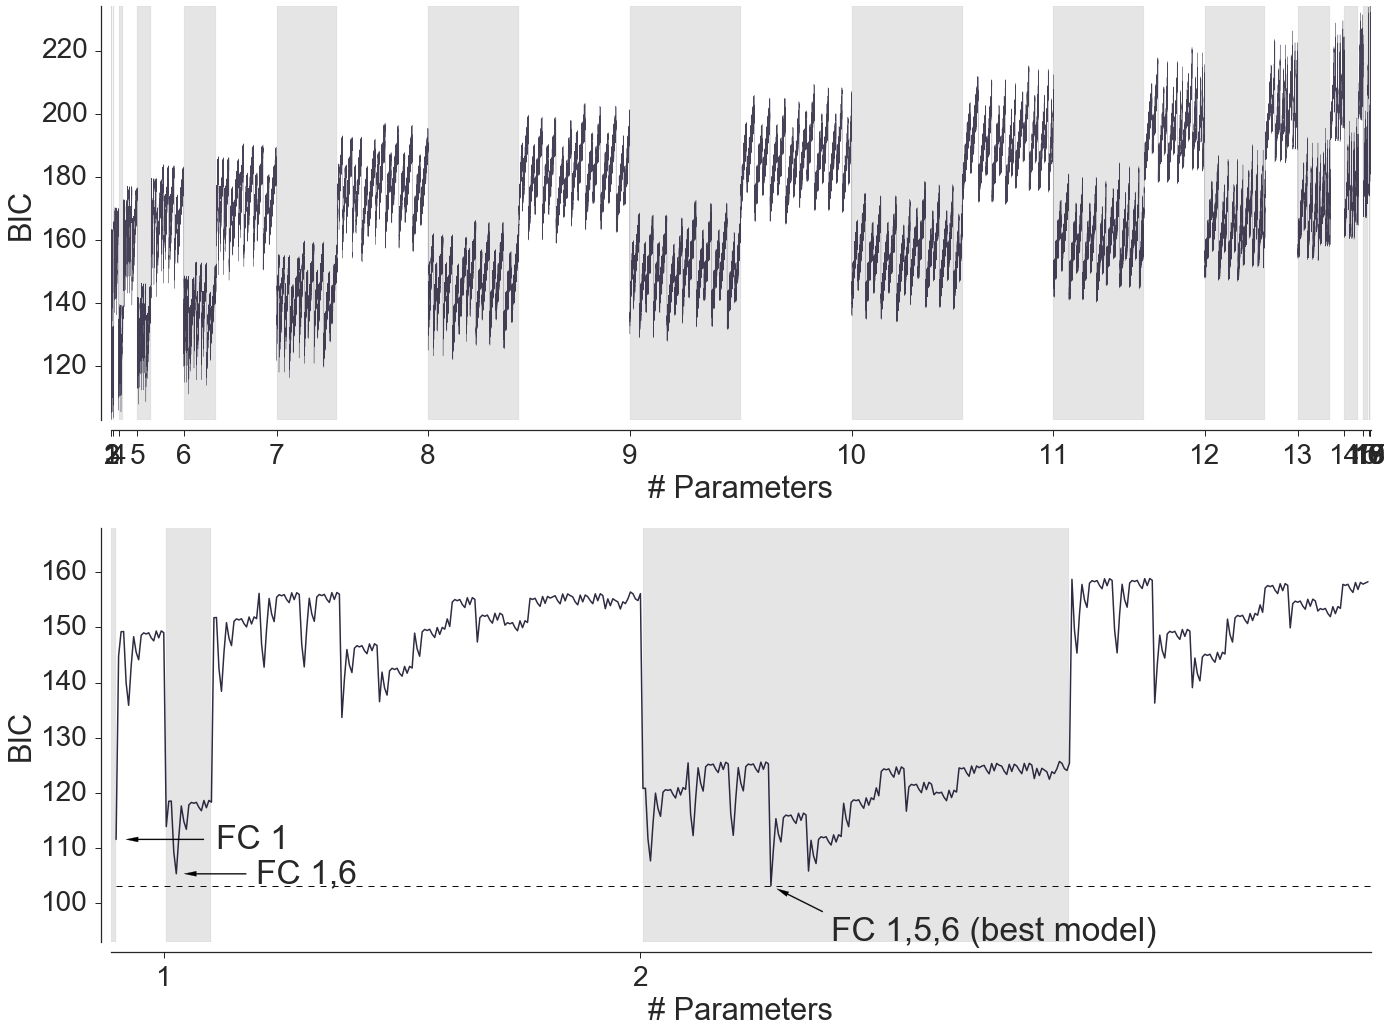

In [114]:
sns.set_context('notebook', font_scale=2.8)
sns.set_style('ticks')

plotmin = int(model_df["BIC"].min())
plotmax = int(model_df["BIC"].max())
plotheight = plotmax - plotmin

fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(211)
plt.plot(range(len(model_df['maps'])), model_df["BIC"], color=colors[1], alpha=.8, linewidth=.3)
plt.ylabel('BIC')
plt.xlabel('# Parameters')
plt.xticks(map_transitions, [x+1 for x in range(20)]);
plt.xlim([-2,model_df.shape[0]])
plt.ylim([plotmin, plotmax])
#ax1.vlines(map_transitions, plotmin, plotmax, linestyle='-', linewidth=3, colors=colors[0])
#for p in np.arange(0,len(patches),2):
#    ax1.add_patch(mpl.patches.Rectangle((patches[p][0], plotmin), len(patches[p]), plotheight,
#                                       fill=False, edgecolor='grey', linewidth=1))
for z in zero_patches:
    ax1.add_patch(mpl.patches.Rectangle((z[0], plotmin), z[1], plotheight,
                                       facecolor='black', alpha=0.1,))
    

upto = 500
smallplotmin = int(model_df["BIC"][:upto].min())-10
smallplotmax = int(model_df["BIC"][:upto].max())+10
smallplotheight = plotmax - plotmin


ax2 = fig.add_subplot(212)
plt.plot(range(len(model_df['maps']))[:upto], model_df["BIC"][:upto], color=colors[1], alpha=.9, linewidth=1.5)
plt.ylabel('BIC')
plt.xlabel('# Parameters')
plt.xticks(map_transitions[np.where(map_transitions<upto)[0]], [x+1 for x in range(20)]);
plt.xlim([-2,upto])
plt.ylim([smallplotmin, smallplotmax])
ax2.hlines(np.min(model_df["BIC"]), 0, upto, linestyle='--', linewidth=1, colors=colors[0])
ax2.annotate('FC 1,5,6 (best model)', xy=(np.argmin(model_df["BIC"]), np.min(model_df["BIC"])), xycoords='data',
            xytext=(60, -30), textcoords='offset points',
            arrowprops=dict(facecolor='black', width=1, headwidth=5, shrink=0.1),
            horizontalalignment='left', verticalalignment='top',
            )
ax2.annotate('FC 1,6', xy=(24, model_df["BIC"][24]), xycoords='data',
            xytext=(80, 0), textcoords='offset points',
            arrowprops=dict(facecolor='black', width=1, headwidth=5, shrink=0.1),
            horizontalalignment='left', verticalalignment='center',
            )
ax2.annotate('FC 1', xy=(0, model_df["BIC"][0]), xycoords='data',
            xytext=(100, 0), textcoords='offset points',
            arrowprops=dict(facecolor='black', width=1, headwidth=5, shrink=0.1),
            horizontalalignment='left', verticalalignment='center',
            )

for z in zero_patches:
    if z[0] < upto:
        ax2.add_patch(mpl.patches.Rectangle((z[0], smallplotmin), z[1], smallplotheight,
                                           facecolor='black', alpha=0.1,))
    
fig.tight_layout()
sns.despine(offset=10)
fig.savefig(pic_folder+'fig2_models.png')

In [27]:
print '0', t1_predict_0['corr'][0], t1_predict_0['score']
print 'best', t1_predict_best['corr'][0], t1_predict_best['score']

0 0.528208342431 0.279004053013
best 0.667511548784 0.445571667761


In [28]:
best_maps=[]
for patch in patches:
    bic_patch = [model_df['BIC'][p] for p in patch]
    best_maps.append(eval(model_df.iloc[patch[np.argmin(bic_patch)]]['maps']))

best_maps_ordered = []
last = list(best_maps[0])
best_maps_ordered.append(list(best_maps[0]))
for b in best_maps[1:]:
    current = list(b)
    for x in last:
        current.remove(x)
    best_maps_ordered.append(last+current)
    last += current
best_maps_ordered

[[0],
 [0, 5],
 [0, 5, 4],
 [0, 5, 4, 6],
 [0, 5, 4, 6, 9],
 [0, 5, 4, 6, 9, 1],
 [0, 5, 4, 6, 9, 1, 8],
 [0, 5, 4, 6, 9, 1, 8, 15],
 [0, 5, 4, 6, 9, 1, 8, 15, 17],
 [0, 5, 4, 6, 9, 1, 8, 15, 17, 14],
 [0, 5, 4, 6, 9, 1, 8, 15, 17, 14, 7],
 [0, 5, 4, 6, 9, 1, 8, 15, 17, 14, 7, 10],
 [0, 5, 4, 6, 9, 1, 8, 15, 17, 14, 7, 10, 12],
 [0, 5, 4, 6, 9, 1, 8, 15, 17, 14, 7, 10, 12, 13],
 [0, 5, 4, 6, 9, 1, 8, 15, 17, 14, 7, 10, 12, 13, 11],
 [0, 5, 4, 6, 9, 1, 8, 15, 17, 14, 7, 10, 12, 13, 11, 19],
 [0, 5, 4, 6, 9, 1, 8, 15, 17, 14, 7, 10, 12, 13, 11, 19, 2],
 [0, 5, 4, 6, 9, 1, 8, 15, 17, 14, 7, 10, 12, 13, 11, 19, 2, 3],
 [0, 5, 4, 6, 9, 1, 8, 15, 17, 14, 7, 10, 12, 13, 11, 19, 2, 3, 16],
 [0, 5, 4, 6, 9, 1, 8, 15, 17, 14, 7, 10, 12, 13, 11, 19, 2, 3, 16, 18]]

## Figure 3

In [170]:
sns.set_style('white')
sns.set_context('poster')
cropped_model = []
for data in [t1_predict_0['modelled_fit'],
             t1_predict_best['modelled_fit']]:
             #t1_predict_0['t1']]:
    for (elev, azim) in [(180, 0), (180, 180)]:
        vmin = 1700 #data[np.where(data>500)].min()
        vmax = 2300 #data[np.where(data>500)].max()
        plot=plot_surf_stat_map(lv, lf, stat_map=data[:lv.shape[0]], bg_map=lh_sulc, bg_on_stat=False, darkness=0.8, 
                                elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1500, cmap='cubehelix_r',
                                vmin=vmin, vmax = vmax,
                                symmetric_cbar=False)
        cropped_model.append(crop_img(plot))

    for (elev, azim) in [(180, 0), (180, 180)]:
        plot=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:], bg_map=rh_sulc, bg_on_stat=False, darkness=0.8, 
                                elev=elev,azim=azim, figsize=(10,7.7) ,threshold=1500, cmap='cubehelix_r',
                                vmin=vmin, vmax=vmax,
                                symmetric_cbar=False)
        cropped_model.append(crop_img(plot))

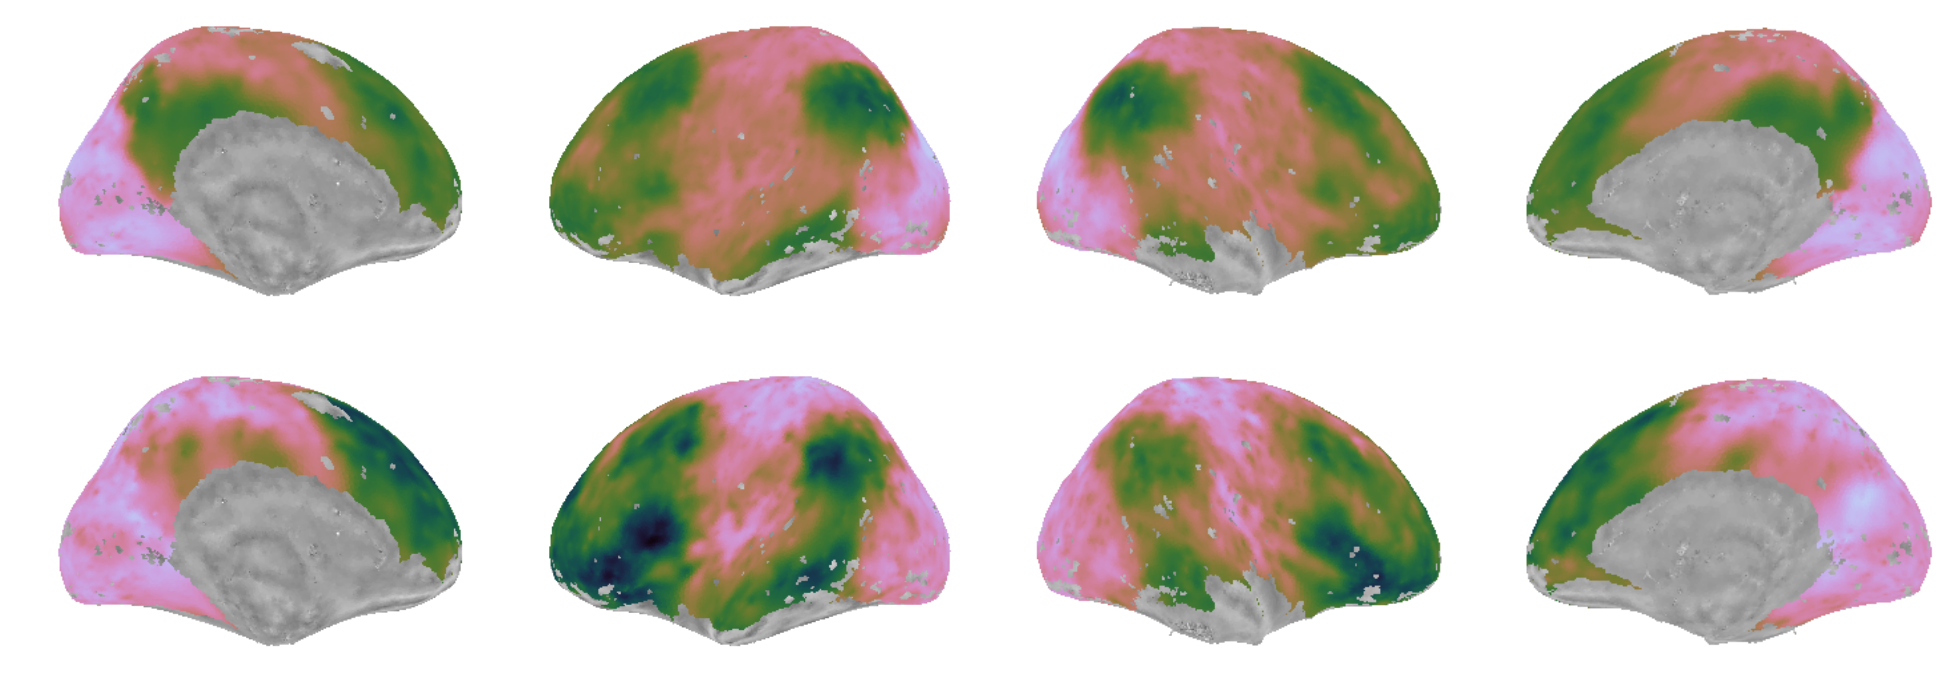

In [171]:
fig =brain_fig(cropped_model)
fig.savefig(pic_folder+'fig3_brains.png')

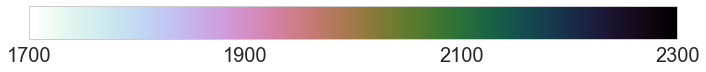

In [32]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=2)

inferno = plt.get_cmap('cubehelix_r')
norm = mpl.colors.Normalize(vmin=1700, vmax=2300)

fig_hcbar = plt.figure(figsize=(10, 3))
ax1 = fig_hcbar.add_axes([0.05, 0.80, 0.9, 0.15])
mpl.colorbar.ColorbarBase(ax1, cmap=inferno,norm=norm,orientation='horizontal', ticks=[1700, 1900, 2100, 2300])

fig_hcbar.savefig(pic_folder+'fig3_bar.svg')
#fig_vcbar = plt.figure(figsize=(10, 8))
#ax1 = fig_vcbar.add_axes([0.05, 0.05, 0.05, 0.9])
#mpl.colorbar.ColorbarBase(ax1, cmap=inferno,norm=norm,orientation='vertical', ticks=[1700, 1900, 2100, 2300])

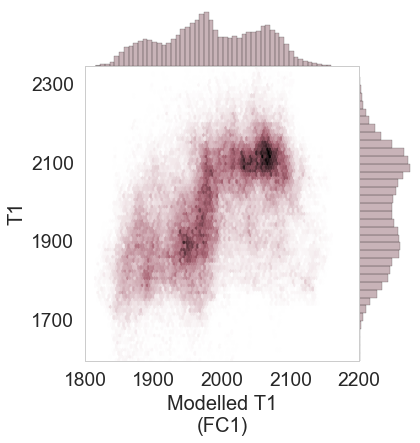

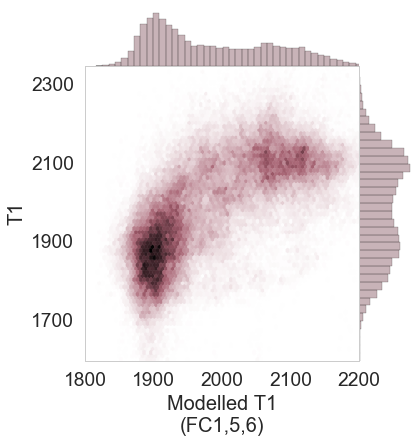

In [33]:
sns.set_style('whitegrid',{'axes.grid': False})
sns.set_context('poster', font_scale=1.2)

scatter_mask = np.where(t1_predict_0['t1']>1500)

xlim = (1800, 2200)
ylim = (1600, 2350)
yticks = [1700, 1900, 2100, 2300]
xticks = [1800, 1900, 2000, 2100, 2200]
scatter_color = sns.xkcd_rgb['brownish purple']
#scatter_color = colors[0]

fig_0 = sns.jointplot(t1_predict_0['modelled_fit'][scatter_mask], 
                      t1_predict_0['t1'][scatter_mask], 
                      xlim=xlim, ylim=ylim, space=0, stat_func=None,
                      kind="hex", size=6, color=scatter_color)
fig_0.set_axis_labels('Modelled T1\n(FC1)', 'T1', fontsize=20)
fig_0.ax_joint.set_xticks(xticks);
fig_0.ax_joint.set_yticks(yticks);
fig_0.savefig(pic_folder+'fig3_scatterFC1.png')

fig_best = sns.jointplot(t1_predict_best['modelled_fit'][scatter_mask], 
                         t1_predict_best['t1'][scatter_mask], 
                         xlim=xlim, ylim=ylim, space=0,stat_func=None,
                         kind="hex", size=6, color=scatter_color)
fig_best.set_axis_labels('Modelled T1\n(FC1,5,6)', 'T1', fontsize=20)
fig_best.ax_joint.set_xticks(xticks);
fig_best.ax_joint.set_yticks(yticks);
fig_best.savefig(pic_folder+'fig3_scatterFC156.png')

## Figure 4

In [12]:
single_hem_files = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/%s_t1avg_by_fc_maps_%s.pkl'
t1_predict_rh_0 = load_pickle(single_hem_files%('rh', '0'))
t1_predict_rh_best = load_pickle(single_hem_files%('rh', 'best'))
t1_predict_rh_all = load_pickle(single_hem_files%('rh', 'all'))
t1_predict_lh_0 = load_pickle(single_hem_files%('lh', '0'))
t1_predict_lh_best = load_pickle(single_hem_files%('lh', 'best'))
t1_predict_lh_all = load_pickle(single_hem_files%('lh', 'all'))


df_0 = pd.read_csv('/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/random/random_by_fc_0.csv', index_col=0)
df_best = pd.read_csv('/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/random/random_by_fc_best.csv', index_col=0)
df_all = pd.read_csv('/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/random/random_by_fc_all.csv', index_col=0)

for col in ['rh corr', 'rh score', 'lh corr', 'lh score']:
    for idx in ['smooth_1.5', 'smooth_3', 'smooth_6', 'smooth_12', 'smooth_24']:
        df_0[col][idx] = eval(df_0[col][idx])
        df_best[col][idx] = eval(df_best[col][idx])
        df_all[col][idx] = eval(df_all[col][idx])

In [13]:
df_0_tidy = pd.DataFrame(columns=["Pearson's r", 'R squared', 'Hemisphere', 'FWHM [mm]'])
df_0_tidy['Hemisphere'] = 5000*['left']+5000*['right']
df_0_tidy['FWHM [mm]'] = 2*(1000*[1.5]+1000*[3]+1000*[6]+1000*[12]+1000*[24])
corrs = []
rs = []
for hemi in ['lh', 'rh']:
    for smooth in ['smooth_1.5', 'smooth_3', 'smooth_6', 'smooth_12', 'smooth_24']:
        corrs += df_0['%s corr'%hemi][smooth]
        rs += df_0['%s score'%hemi][smooth]
df_0_tidy["Pearson's r"] = corrs
df_0_tidy['R squared'] = rs



df_best_tidy = pd.DataFrame(columns=["Pearson's r", 'R squared', 'Hemisphere', 'FWHM [mm]'])
df_best_tidy['Hemisphere'] = 5000*['left']+5000*['right']
df_best_tidy['FWHM [mm]'] = 2*(1000*[1.5]+1000*[3]+1000*[6]+1000*[12]+1000*[24])
corrs = []
rs = []
for hemi in ['lh', 'rh']:
    for smooth in ['smooth_1.5', 'smooth_3', 'smooth_6', 'smooth_12', 'smooth_24']:
        corrs += df_best['%s corr'%hemi][smooth]
        rs += df_best['%s score'%hemi][smooth]
df_best_tidy["Pearson's r"] = corrs
df_best_tidy['R squared'] = rs

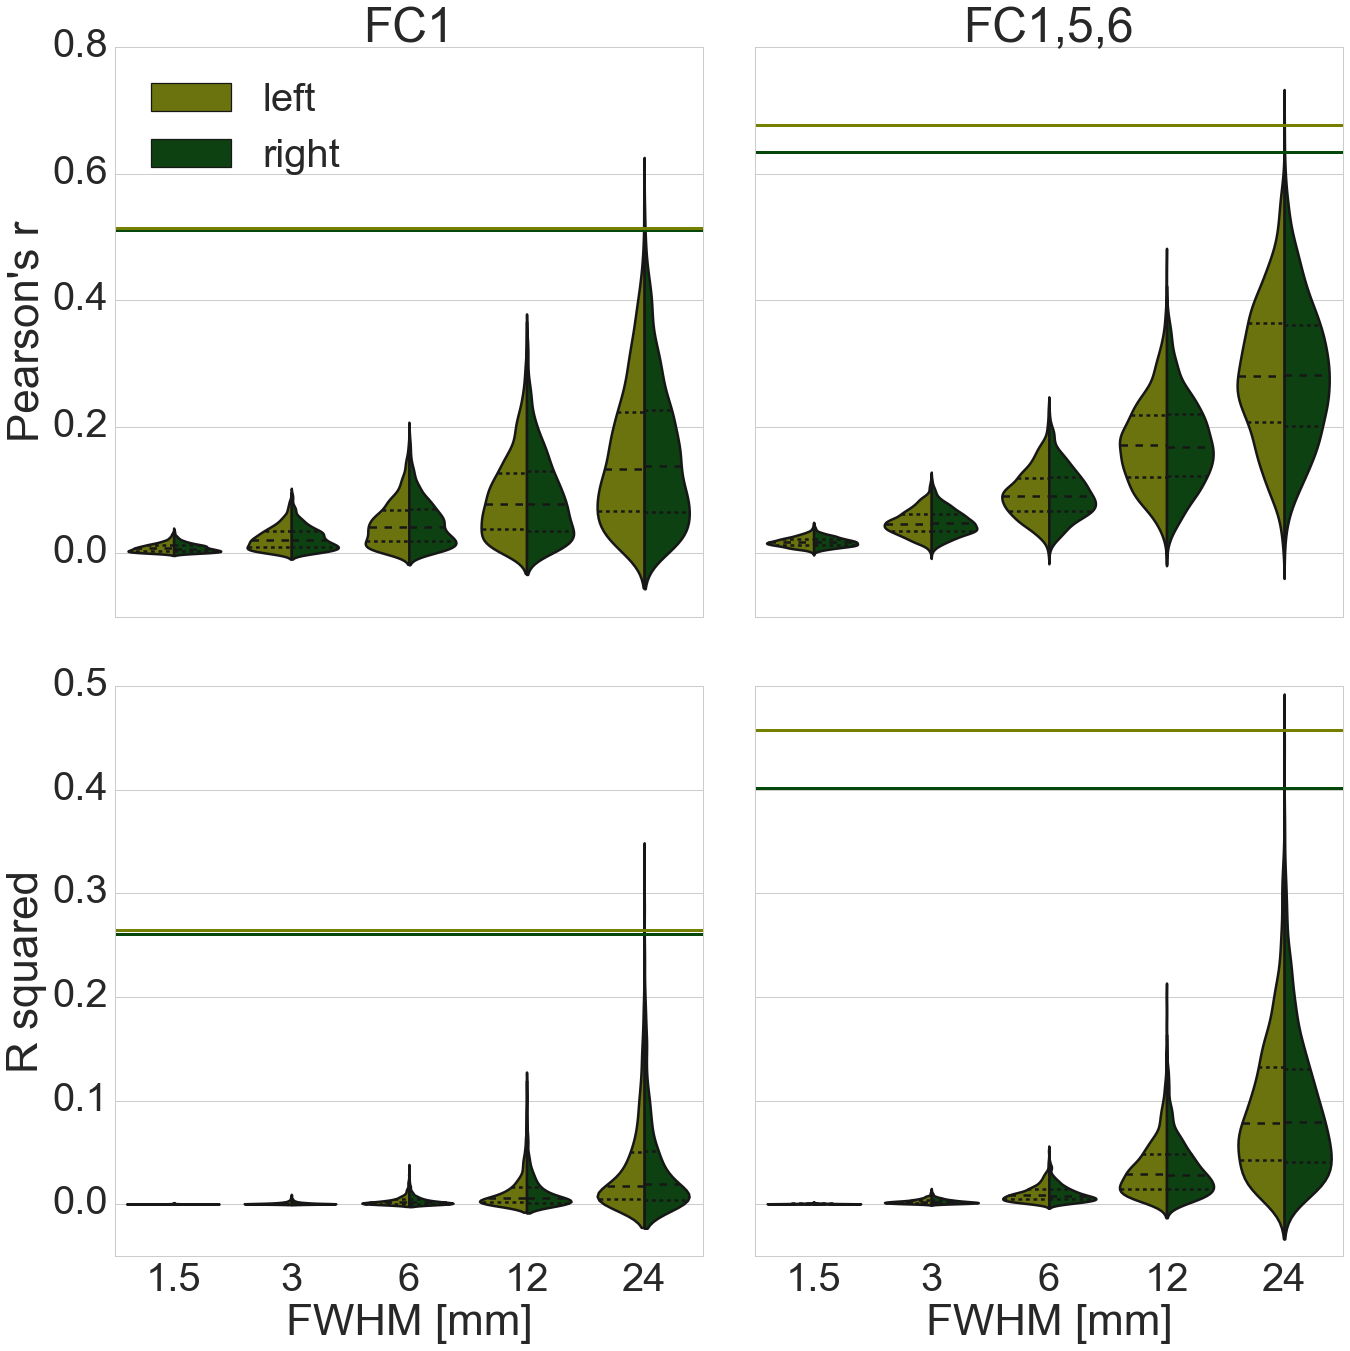

In [40]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=4)
cright = sns.xkcd_rgb['forest green'] #sns.xkcd_rgb['marine blue'] #colors[0]
cleft = sns.xkcd_rgb['shit green'] #sns.xkcd_rgb['grass green'] #colors[11]
sat = .8
lin = 2.5
lw=3
fig = plt.figure(figsize=(20,20))
crline= cright  #sns.xkcd_rgb['marine blue']  #colors[0] #sns.xkcd_rgb['rich purple']
clline=cleft  #sns.xkcd_rgb['grass green'] #colors[11]

fig.add_subplot(221)
ax1 = sns.violinplot(x = 'FWHM [mm]', y="Pearson's r", hue='Hemisphere', data=df_0_tidy, 
               split=True, palette=[cleft,cright], inner='quartile', saturation=sat, linewidth=lin); 
ax1.hlines(t1_predict_rh_0['corr'][0], -1, 5, linestyle='-', linewidth=lw, colors=crline)
ax1.hlines(t1_predict_lh_0['corr'][0], -1, 5, linestyle='-', linewidth=lw, colors=clline)
plt.legend(loc=2)
plt.xticks([0, 1, 2, 3, 4], [])#['1.5', '3', '6','12', '24'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8])
plt.xlabel('')
plt.ylim([-0.1,0.8])
plt.title('FC1')


fig.add_subplot(222)
ax3 = sns.violinplot(x = 'FWHM [mm]', y="Pearson's r", hue='Hemisphere', data=df_best_tidy, 
               split=True, palette=[cleft,cright], inner='quartile', saturation=sat, linewidth=lin); 
ax3.hlines(t1_predict_rh_best['corr'][0], -1, 5, linestyle='-', linewidth=lw, colors=crline)
ax3.hlines(t1_predict_lh_best['corr'][0], -1, 5, linestyle='-', linewidth=lw, colors=clline)
ax3.legend_.remove()
plt.xticks([0, 1, 2, 3, 4], [])#['1.5', '3', '6','12', '24'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8],[])
plt.ylabel('')
plt.xlabel('')
plt.ylim([-0.1,0.8])
plt.title('FC1,5,6')


fig.add_subplot(223)
ax2 = sns.violinplot(x = 'FWHM [mm]', y='R squared', hue='Hemisphere', data=df_0_tidy, 
               split=True, palette=[cleft,cright], inner='quartile', saturation=sat, linewidth=lin); 
ax2.hlines(t1_predict_rh_0['score'], -1, 5, linestyle='-', linewidth=lw, colors=crline)
ax2.hlines(t1_predict_lh_0['score'], -1, 5, linestyle='-', linewidth=lw, colors=clline)
ax2.legend_.remove()
plt.xticks([0, 1, 2, 3, 4], ['1.5', '3', '6','12', '24'])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.ylim([-0.05,0.5])



fig.add_subplot(224)
ax4 = sns.violinplot(x = 'FWHM [mm]', y='R squared', hue='Hemisphere', data=df_best_tidy, 
               split=True, palette=[cleft,cright], inner='quartile', saturation=sat, linewidth=lin);
ax4.hlines(t1_predict_rh_best['score'], -1, 5, linestyle='-', linewidth=lw, colors=crline)
ax4.hlines(t1_predict_lh_best['score'], -1, 5, linestyle='-', linewidth=lw, colors=clline)
ax4.legend_.remove()
plt.xticks([0, 1, 2, 3, 4], ['1.5', '3', '6','12', '24'])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5],[])
plt.ylabel('')
plt.ylim([-0.05,0.5])


fig.tight_layout()
fig.savefig(pic_folder+'fig4.png')

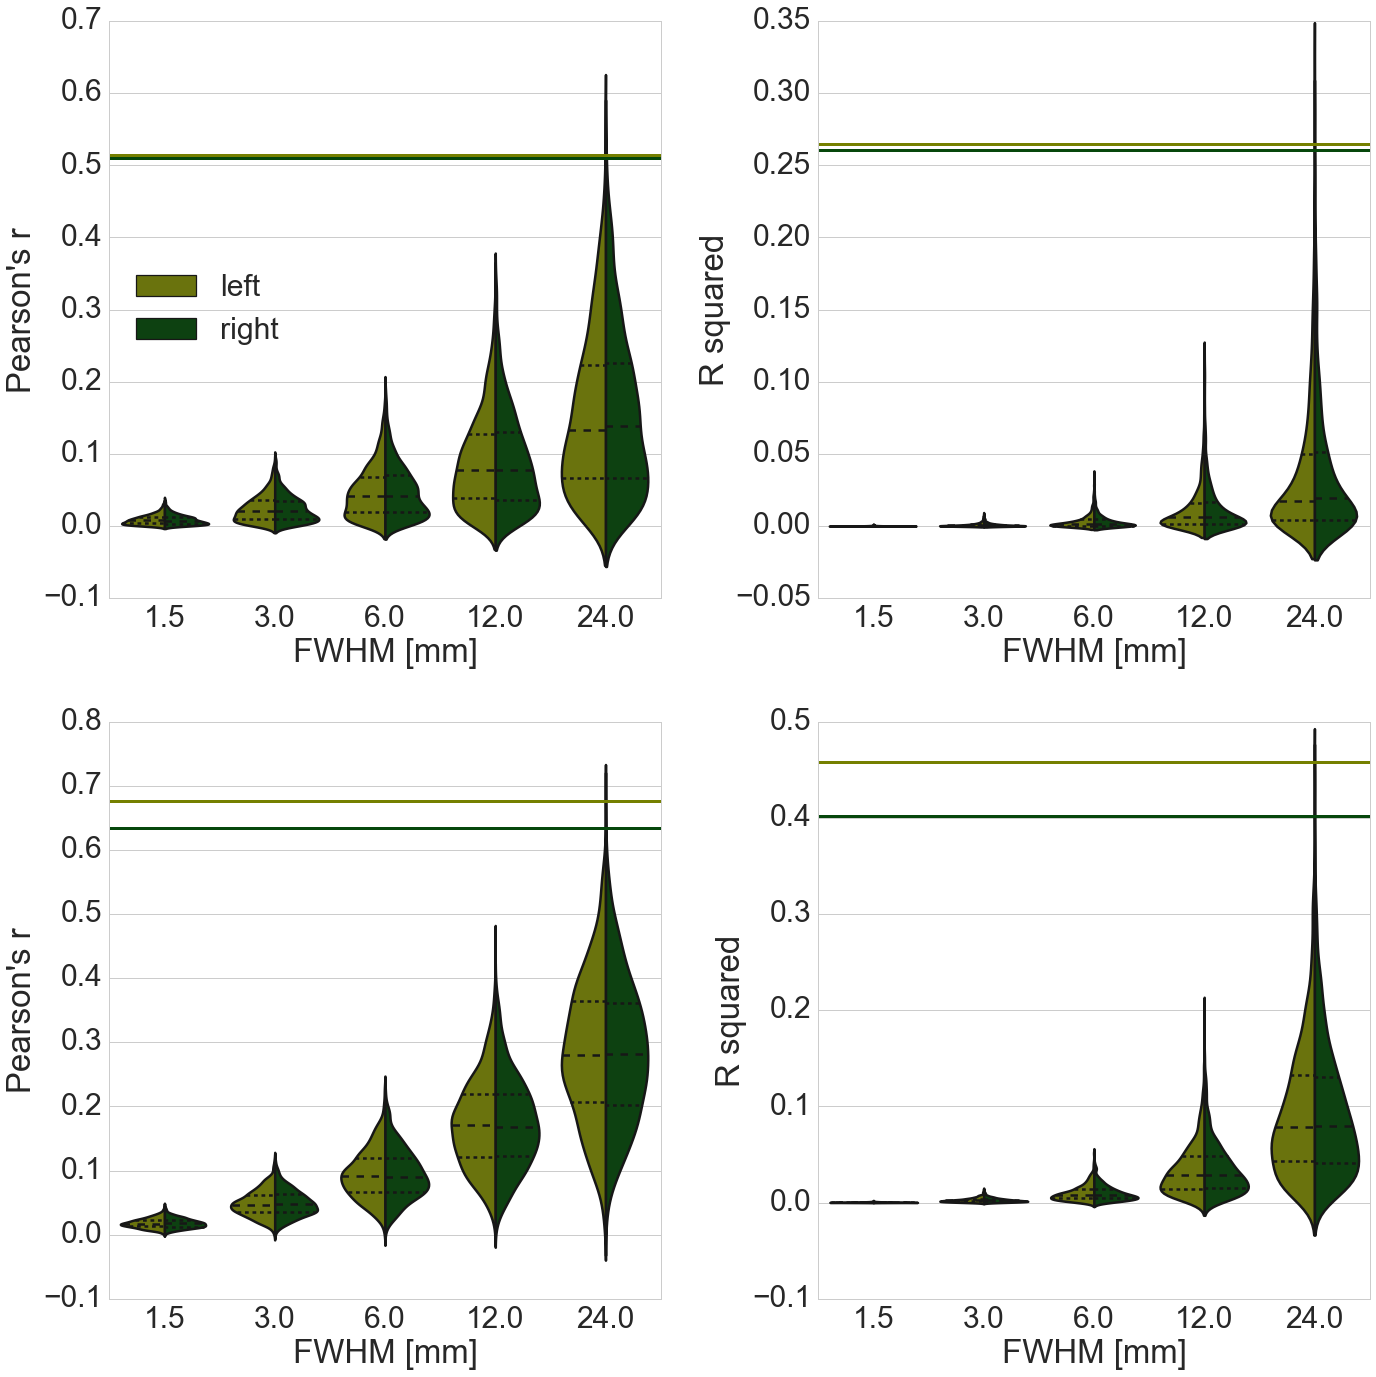

In [36]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=3)
cright = sns.xkcd_rgb['forest green'] #sns.xkcd_rgb['marine blue'] #colors[0]
cleft = sns.xkcd_rgb['shit green'] #sns.xkcd_rgb['grass green'] #colors[11]
sat = .8
lin = 2.5
lw=3
fig = plt.figure(figsize=(20,20))
crline= cright  #sns.xkcd_rgb['marine blue']  #colors[0] #sns.xkcd_rgb['rich purple']
clline=cleft  #sns.xkcd_rgb['grass green'] #colors[11]

fig.add_subplot(221)
ax1 = sns.violinplot(x = 'FWHM [mm]', y="Pearson's r", hue='Hemisphere', data=df_0_tidy, 
               split=True, palette=[cleft,cright], inner='quartile', saturation=sat, linewidth=lin); 
ax1.hlines(t1_predict_rh_0['corr'][0], -1, 5, linestyle='-', linewidth=lw, colors=crline)
ax1.hlines(t1_predict_lh_0['corr'][0], -1, 5, linestyle='-', linewidth=lw, colors=clline)
plt.legend(loc=6)

fig.add_subplot(222)
ax2 = sns.violinplot(x = 'FWHM [mm]', y='R squared', hue='Hemisphere', data=df_0_tidy, 
               split=True, palette=[cleft,cright], inner='quartile', saturation=sat, linewidth=lin); 
ax2.hlines(t1_predict_rh_0['score'], -1, 5, linestyle='-', linewidth=lw, colors=crline)
ax2.hlines(t1_predict_lh_0['score'], -1, 5, linestyle='-', linewidth=lw, colors=clline)
ax2.legend_.remove()

fig.add_subplot(223)
ax3 = sns.violinplot(x = 'FWHM [mm]', y="Pearson's r", hue='Hemisphere', data=df_best_tidy, 
               split=True, palette=[cleft,cright], inner='quartile', saturation=sat, linewidth=lin); 
ax3.hlines(t1_predict_rh_best['corr'][0], -1, 5, linestyle='-', linewidth=lw, colors=crline)
ax3.hlines(t1_predict_lh_best['corr'][0], -1, 5, linestyle='-', linewidth=lw, colors=clline)
ax3.legend_.remove()

fig.add_subplot(224)
ax4 = sns.violinplot(x = 'FWHM [mm]', y='R squared', hue='Hemisphere', data=df_best_tidy, 
               split=True, palette=[cleft,cright], inner='quartile', saturation=sat, linewidth=lin);
ax4.hlines(t1_predict_rh_best['score'], -1, 5, linestyle='-', linewidth=lw, colors=crline)
ax4.hlines(t1_predict_lh_best['score'], -1, 5, linestyle='-', linewidth=lw, colors=clline)
ax4.legend_.remove()

fig.tight_layout()
fig.savefig(pic_folder+'fig4.png')

## Figure 5

In [95]:
Gl = graph_from_mesh(lv, lf)
Gr = graph_from_mesh(rv, rf)

embed_0 = -embed[:,0]

#p=20
#thresh=int((embed_0[embed_0!=0].shape[0]*p)/100)
thresh_high = 1#sorted(embed_0[embed_0!=0])[-thresh:][0]
thresh_low = -1.5#sorted(embed_0[embed_0!=0])[:thresh][-1]

embed_0_high = np.zeros_like(embed_0)
embed_0_high[embed_0>thresh_high]=embed_0[embed_0>thresh_high]
embed_0_low = np.zeros_like(embed_0)
embed_0_low[embed_0<thresh_low]=embed_0[embed_0<thresh_low]
embed_0_combined = embed_0_high+embed_0_low

sub_Gl_low = nx.subgraph(Gl, np.where(embed_0_low[:lv.shape[0]]!=0)[0])
sub_Gr_low = nx.subgraph(Gr, np.where(embed_0_low[lv.shape[0]:]!=0)[0])
sub_Gl_high = nx.subgraph(Gl, np.where(embed_0_high[:lv.shape[0]]!=0)[0])
sub_Gr_high = nx.subgraph(Gr, np.where(embed_0_high[lv.shape[0]:]!=0)[0])

clust_Gl_low = sorted(nx.connected_components(sub_Gl_low), key=len, reverse=True)
clust_Gr_low = sorted(nx.connected_components(sub_Gr_low), key=len, reverse=True)
clust_Gl_high = sorted(nx.connected_components(sub_Gl_high), key=len, reverse=True)
clust_Gr_high = sorted(nx.connected_components(sub_Gr_high), key=len, reverse=True)


In [96]:
brain_Gl = np.zeros(lv.shape[0])
brain_Gr = np.zeros(rv.shape[0])

colors_low = [-2,-1]
colors_high = [3, 2, 1]

for bc in range(3):
    #brain_Gl[list(clust_Gl_high[bc])]=np.mean(embed_0[list(clust_Gl_high[bc])])
    #brain_Gr[list(clust_Gr_high[bc])]=np.mean(embed_0[list(clust_Gr_high[bc])])
    brain_Gl[list(clust_Gl_high[bc])]=colors_high[bc]
    brain_Gr[list(clust_Gr_high[bc])]=colors_high[bc]
for bc in range(2):
    #brain_Gl[list(clust_Gl_low[bc])]=np.mean(embed_0[list(clust_Gl_low[bc])])
    #brain_Gr[list(clust_Gr_low[bc])]=np.mean(embed_0[list(clust_Gr_low[bc])])
    brain_Gl[list(clust_Gl_low[bc])]=colors_low[bc]
    brain_Gr[list(clust_Gr_low[bc])]=colors_low[bc]


In [174]:
sns.set_style('white')
sns.set_context('poster')
cropped_res_mask = []

for (elev, azim) in [(180, 0), (180, 180)]:
    plot_lh=plot_surf_stat_map(lv, lf, stat_map=np.concatenate((brain_Gl, brain_Gr))[:lv.shape[0]], 
                               bg_map=lh_sulc, bg_on_stat=False, darkness=0.6, 
                        elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1e-50, cmap='cubehelix_r',
                        symmetric_cbar=False, 
                                vmin=-4,
                              vmax=4)
    cropped_res_mask.append(crop_img(plot_lh))

for (elev, azim) in [(180, 0), (180, 180)]:
    plot_rh=plot_surf_stat_map(rv, rf, stat_map=np.concatenate((brain_Gl, brain_Gr))[lv.shape[0]:], 
                               bg_map=rh_sulc, bg_on_stat=False, darkness=0.6, 
                        elev=elev,azim=azim, figsize=(10,7.7) ,threshold=1e-50, cmap='cubehelix_r',
                        symmetric_cbar=False,
                              vmin=-4,
                              vmax=4)
    cropped_res_mask.append(crop_img(plot_rh))

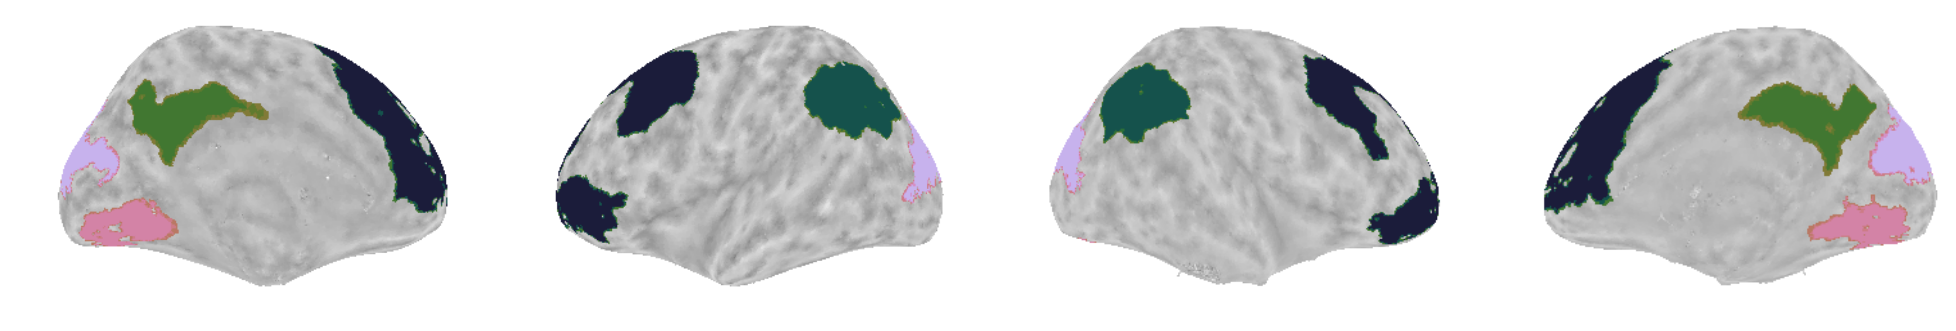

In [175]:
fig=brain_fig(cropped_res_mask)
sns.set_context('poster')
fig.savefig(pic_folder+'fig4_brains.png')

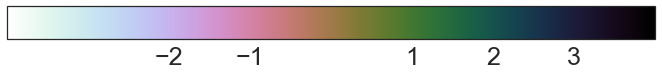

In [139]:
## sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=2.5)
norm_embed = mpl.colors.Normalize(vmin=-4, vmax=4)
fig_hcbar = plt.figure(figsize=(10, 3))
ax1 = fig_hcbar.add_axes([0.05, 0.80, 0.9, 0.15])
mpl.colorbar.ColorbarBase(ax1, cmap=cubehelix,norm=norm_embed,orientation='horizontal', ticks=[-2, -1, 1, 2, 3])



In [176]:
procolor= 2*(sns.color_palette('cubehelix_r',8)[1:3]+sns.color_palette('cubehelix_r',8)[5:8])

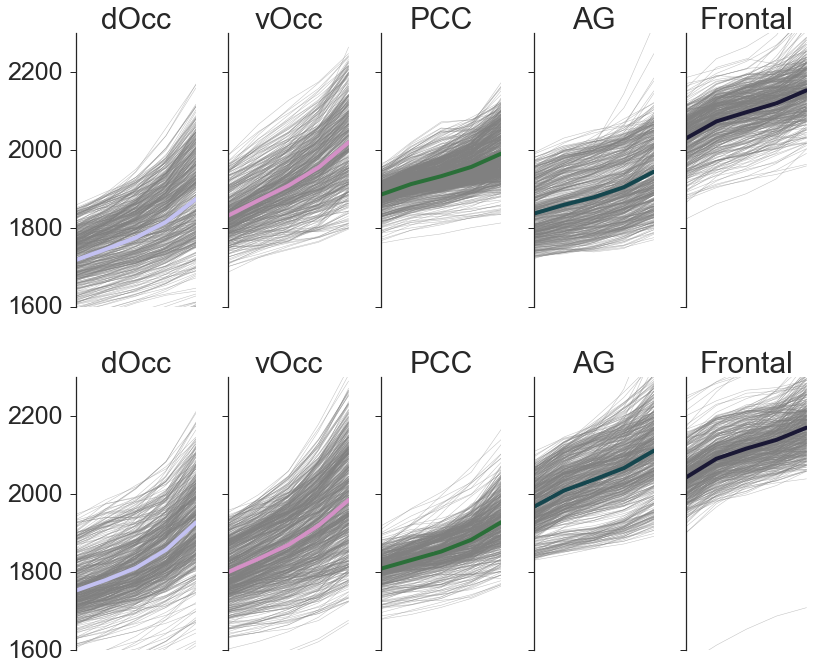

In [184]:
sns.set_context('notebook', font_scale=2.5)
profiles_lh = np.load('/scr/ilz3/myelinconnect/new_groupavg/profiles/smooth_3/lh_group_avg_profiles_smooth_3.npy')
profiles_rh = np.load('/scr/ilz3/myelinconnect/new_groupavg/profiles/smooth_3/rh_group_avg_profiles_smooth_3.npy')

lh_front = profiles_lh[np.where(brain_Gl==3)]
rh_front = profiles_rh[np.where(brain_Gr==3)]

lh_latp = profiles_lh[np.where(brain_Gl==2)]
rh_latp = profiles_rh[np.where(brain_Gr==2)]

lh_pcc = profiles_lh[np.where(brain_Gl==1)]
rh_pcc = profiles_rh[np.where(brain_Gr==1)]

lh_ven = profiles_lh[np.where(brain_Gl==-1)]
rh_ven = profiles_rh[np.where(brain_Gr==-1)]

lh_dors = profiles_lh[np.where(brain_Gl==-2)]
rh_dors = profiles_rh[np.where(brain_Gr==-2)]

sns.set_style('ticks')
data=[lh_dors, lh_ven, lh_pcc, lh_latp, lh_front, rh_dors, rh_ven, rh_pcc, rh_latp, rh_front]
titles=2*['dOcc', 'vOcc', 'PCC', 'AG', 'Frontal']
fig = plt.figure(figsize=(12,10))
for i in range(len(data)):
    ax = fig.add_subplot(2,5,i+1)
    ax.set_ylim([1600, 2300])
    for pro in data[i][0::int(len(data[i])/500)]:
        plt.plot(pro[3:8],color='gray', alpha=0.5, linewidth=0.5)
    plt.plot(np.mean(data[i], axis=0)[3:8], color=procolor[i], linewidth=4)
    plt.xticks([])
    plt.title(titles[i])
    if np.mod(i,5)==0:
        plt.yticks(np.arange(1600, 2400, 200))
    else:
        plt.yticks(np.arange(1600, 2400, 200),[])
sns.despine(bottom=True)
fig.tight_layout()
fig.savefig(pic_folder+'fig4_allproflies.png')

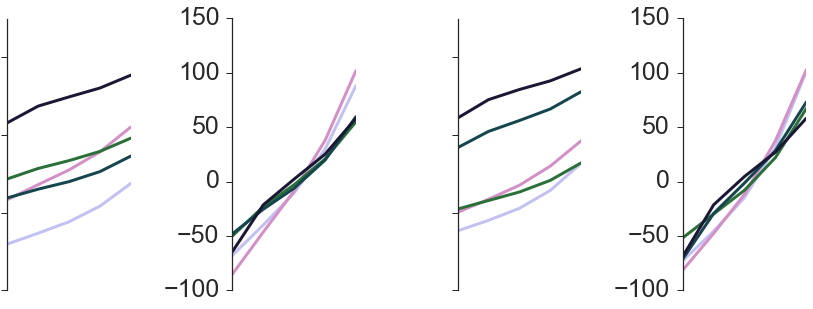

In [186]:
sns.set_context('notebook', font_scale=2.5)
sns.set_style('ticks')
data_left=data[:5]
data_right=data[5:]
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,4,1)
ax1.set_ylim([1600, 2300])
plt.xticks([])
plt.yticks(np.arange(1600, 2400, 200),[])
for i in range(len(data_left)):
    plt.plot(np.mean(data_left[i], axis=0)[3:8], color=procolor[i], linewidth=3)
    
ax2 = fig.add_subplot(1,4,3)
ax2.set_ylim([1600, 2300])
plt.xticks([])
plt.yticks(np.arange(1600, 2400, 200),[])
for i in range(len(data_right)):
    plt.plot(np.mean(data_right[i], axis=0)[3:8], color=procolor[i], linewidth=3)
    
ax3 = fig.add_subplot(1,4,2)
plt.xticks([])
for i in range(len(data_left)):
    plt.plot(np.mean(data_left[i], axis=0)[3:8]-np.mean(data_left[i][:,3:8]), color=procolor[i], linewidth=3)   
    
ax4 = fig.add_subplot(1,4,4)
plt.xticks([])
for i in range(len(data_right)):
    plt.plot(np.mean(data_right[i], axis=0)[3:8]-np.mean(data_right[i][:,3:8]), color=procolor[i], 
             linewidth=3, label=titles[i])    
#plt.legend(loc=)
    
    
sns.despine(bottom=True)
fig.tight_layout()
fig.savefig(pic_folder+'fig4_meanproflies.png')

# Supplementary

## Single subjects

In [189]:
subjects = pd.read_csv('/scr/ilz3/myelinconnect/subjects.csv')
subjects=list(subjects['DB'])
subjects.remove('KSMT')

### combined sessions

In [371]:
indv_comb_file = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1indv/smooth_1.5/%s_combined_t1avg_by_fc_maps_%s.pkl'
df_indv_comb = pd.DataFrame(columns=['score', 'corr', 'maps', 'sub'])
sub_list = []
maps_list = []
corr_list = []
score_list = []

for sub in subjects:
    for maps in ['0', 'all']:
        indv_data = load_pickle(indv_comb_file%(sub, maps))
        sub_list.append(sub)
        maps_list.append(maps)
        corr_list.append(indv_data['corr'][0])
        score_list.append(indv_data['score'])
                     
df_indv_comb['maps'] = maps_list
df_indv_comb['sub'] = sub_list
df_indv_comb['score'] = score_list
df_indv_comb['corr'] = corr_list

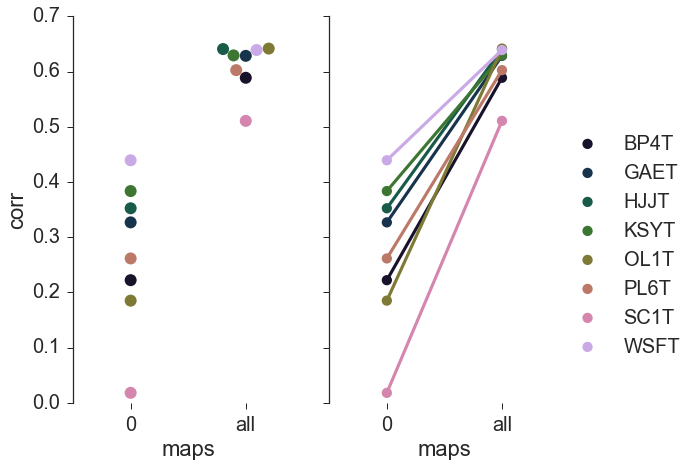

In [612]:
sns.set_context('notebook', font_scale=2)
sns.set_style('ticks')
fig = plt.figure(figsize=(8.4,7))
ax1=fig.add_subplot(121)
sns.swarmplot(x="maps", y="corr", hue="sub", data=df_indv_comb, palette=sns.color_palette('cubehelix', 10), size=12);
plt.ylim([0,.7])
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax1.legend_.remove()

ax2=fig.add_subplot(122)
sns.pointplot(x="maps", y="corr", hue="sub", data=df_indv_comb, palette=sns.color_palette('cubehelix', 10), size=12);
plt.ylim([0,.7])
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7], [])
plt.legend(loc=(1,.1))
plt.ylabel('')


sns.despine(bottom=True)
fig.tight_layout()

### single sessions

In [614]:
indv_data_file = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1indv/smooth_1.5/%s_%s_t1avg_by_fc_maps_%s.pkl'
df_indv = pd.DataFrame(columns=['sess', 'score', 'corr', 'maps', 'sub'])

sub_list = []
maps_list = []
sess_list = []
corr_list = []
score_list = []

for sub in subjects:
    for maps in ['0', 'all']:
        for sess in ['sess1', 'sess2']:
            
            indv_data = load_pickle(indv_data_file%(sub, sess, maps))
            sub_list.append(sub)
            maps_list.append(maps)
            sess_list.append(sess)
            corr_list.append(indv_data['corr'][0])
            score_list.append(indv_data['score'])
                     
df_indv['maps'] = maps_list
df_indv['sub'] = sub_list
df_indv['sess'] = sess_list
df_indv['score'] = score_list
df_indv['corr'] = corr_list

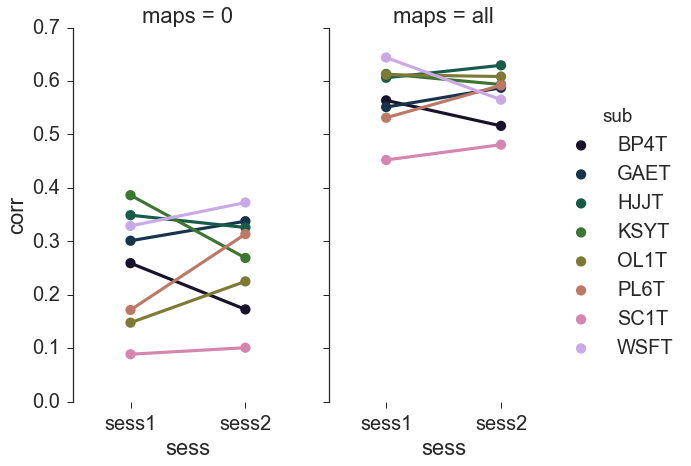

In [617]:
sns.set_context('notebook', font_scale=2)
sns.set_style('ticks')
fig = sns.factorplot(x="sess", y="corr", hue="sub", data=df_indv, col="maps", 
               kind='point', palette=sns.color_palette('cubehelix', 10),
              size=7, aspect=.6);

sns.despine(bottom=True)

## Effect of 5 and 6

In [ ]:
sns.set_style('white')
cropped_model = []
for data in [t1_predict_0['modelled_fit'],
             t1_predict_04['modelled_fit'], t1_predict_05['modelled_fit'],
             t1_predict_best['modelled_fit'], t1_predict_all['modelled_fit'],
             t1_predict_0['t1']]:
    for (elev, azim) in [(180, 0), (180, 180)]:
        vmin = 1700 #data[np.where(data>500)].min()
        vmax = 2300 #data[np.where(data>500)].max()
        plot=plot_surf_stat_map(lv, lf, stat_map=data[:lv.shape[0]], bg_map=lh_sulc, bg_on_stat=True, darkness=0.5, 
                                elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1500, cmap='cubehelix',
                                vmin=vmin, vmax = vmax,
                                symmetric_cbar=False)
        cropped_model.append(crop_img(plot))

    for (elev, azim) in [(180, 0), (180, 180)]:
        plot=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:], bg_map=rh_sulc, bg_on_stat=True, darkness=0.5, 
                                elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1500, cmap='cubehelix',
                                vmin=vmin, vmax=vmax,
                                symmetric_cbar=False)
        cropped_model.append(crop_img(plot))

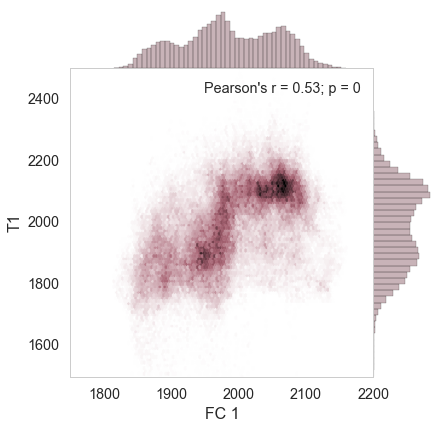

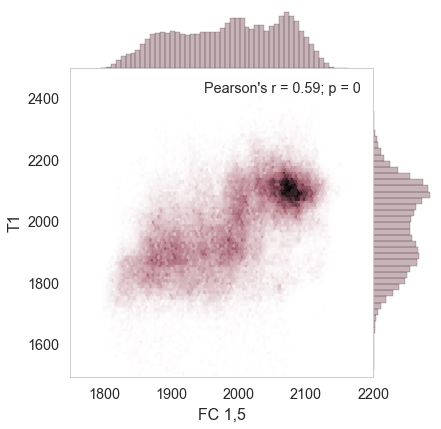

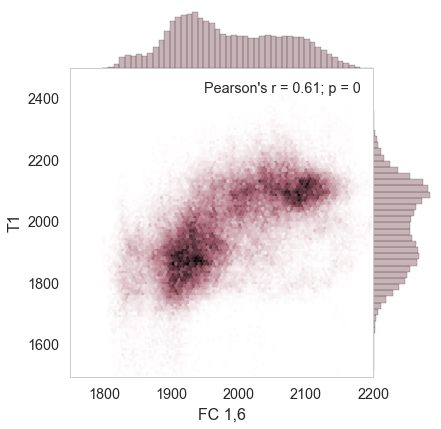

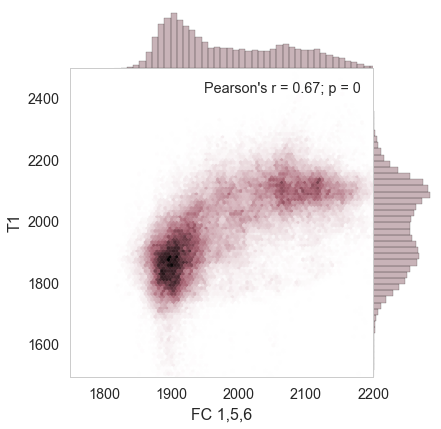

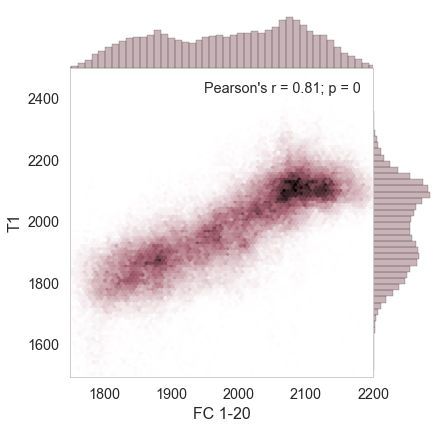

In [592]:
sns.set_style('whitegrid',{'axes.grid': False})
sns.set_context('poster', font_scale=.9)

scatter_mask = np.where(t1_predict_0['t1']>1500)

xlim = (1750, 2200)
#ylim = (1750, 2200)
xticks = [1800, 1900, 2000, 2100, 2200]
scatter_color = sns.xkcd_rgb['brownish purple']
#scatter_color = colors[0]

fig_0 = sns.jointplot(t1_predict_0['modelled_fit'][scatter_mask], 
                      t1_predict_0['t1'][scatter_mask], 
                      xlim=xlim, space=0, 
                      annot_kws=dict(stat="Pearson's r"),
                      kind="hex", size=6, color=scatter_color)
fig_0.set_axis_labels('FC 1', 'T1', fontsize=16)
fig_0.ax_joint.set_xticks(xticks);
fig_0.savefig('/scr/ilz3/myelinconnect/new_groupavg/pics/ohbm_poster/scatter0.png')

fig_04 = sns.jointplot(t1_predict_04['modelled_fit'][scatter_mask], 
                      t1_predict_04['t1'][scatter_mask], 
                      xlim=xlim, 
                       space=0, 
                      annot_kws=dict(stat="Pearson's r"),
                      kind="hex", size=6, color=scatter_color)
fig_04.set_axis_labels('FC 1,5', 'T1', fontsize=16)
fig_04.ax_joint.set_xticks(xticks);
fig_04.savefig('/scr/ilz3/myelinconnect/new_groupavg/pics/ohbm_poster/scatter5.png')

fig_05 = sns.jointplot(t1_predict_05['modelled_fit'][scatter_mask], 
                      t1_predict_05['t1'][scatter_mask], 
                      xlim=xlim, 
                       space=0, 
                      annot_kws=dict(stat="Pearson's r"),
                      kind="hex", size=6, color=scatter_color)
fig_05.set_axis_labels('FC 1,6', 'T1', fontsize=16)
fig_05.ax_joint.set_xticks(xticks);
fig_05.savefig('/scr/ilz3/myelinconnect/new_groupavg/pics/ohbm_poster/scatter6.png')

fig_best = sns.jointplot(t1_predict_best['modelled_fit'][scatter_mask], 
                         t1_predict_best['t1'][scatter_mask], 
                         xlim=xlim, space=0,
                         annot_kws=dict(stat="Pearson's r"),
                         kind="hex", size=6, color=scatter_color)
fig_best.set_axis_labels('FC 1,5,6', 'T1', fontsize=16)
fig_best.ax_joint.set_xticks(xticks);
fig_best.savefig('/scr/ilz3/myelinconnect/new_groupavg/pics/ohbm_poster/best.png')

fig_all = sns.jointplot(t1_predict_all['modelled_fit'][scatter_mask], 
                        t1_predict_all['t1'][scatter_mask], 
                        xlim=xlim, space=0,
                        annot_kws=dict(stat="Pearson's r"),
                        kind="hex", size=6, color=scatter_color)
fig_all.set_axis_labels('FC 1-20', 'T1', fontsize=16)
fig_all.ax_joint.set_xticks(xticks);
fig_all.savefig('/scr/ilz3/myelinconnect/new_groupavg/pics/ohbm_poster/all.png')

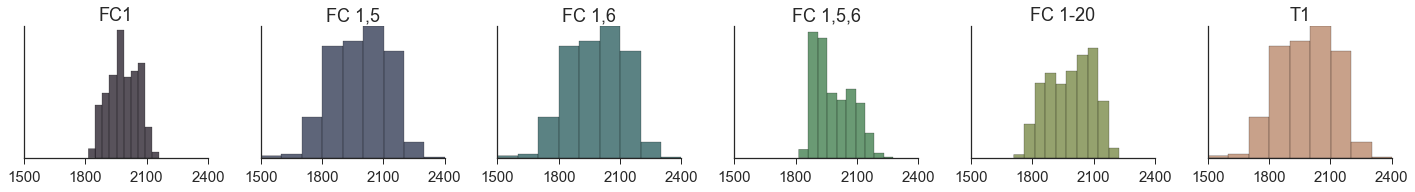

In [662]:
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)
histdata = [t1_predict_0['modelled_fit'][np.where(t1_predict_0['modelled_fit']>500)],
            t1_predict_04['t1'][np.where(t1_predict_0['t1']>500)],
            t1_predict_05['t1'][np.where(t1_predict_0['t1']>500)], 
            t1_predict_best['modelled_fit'][np.where(t1_predict_best['modelled_fit']>500)],
            t1_predict_all['modelled_fit'][np.where(t1_predict_all['modelled_fit']>500)],
            t1_predict_0['t1'][np.where(t1_predict_0['t1']>500)]
           ]

titles = ['FC1', 'FC 1,5', 'FC 1,6', 'FC 1,5,6', 'FC 1-20', 'T1']
fig=plt.figure(figsize=(20,3))

for i in range(len(histdata)):
    fig.add_subplot(1,6,i+1)
    plt.hist(histdata[i], color=colors[2*i], alpha=0.7);
    plt.title(titles[i])
    plt.xlim([1500,2400])
    plt.xticks([1500, 1800, 2100, 2400])
    #plt.ylim([0,30000])
    plt.yticks([])

fig.tight_layout()
sns.despine()

## Residuals

In [624]:
data_res = [t1_predict_0['residuals'], 
            t1_predict_05['residuals'], t1_predict_04['residuals'], 
            t1_predict_best['residuals'], t1_predict_all['residuals']]

vmax = max(np.abs([data.min() for data in data_res]+[data.max() for data in data_res]))

sns.set_style('white')
sns.set_context('poster')
cropped_res = []

for data in data_res:
    for (elev, azim) in [(180, 0), (180, 180)]:
        plot_lh=plot_surf_stat_map(lv, lf, stat_map=data[:lv.shape[0]], bg_map=lh_sulc, bg_on_stat=True, darkness=0.4, 
                            elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1e-50, cmap='RdBu_r',
                            vmax=vmax, symmetric_cbar='auto')
        cropped_res.append(crop_img(plot_lh))
        
    for (elev, azim) in [(180, 0), (180, 180)]:
        plot_rh=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:], bg_map=rh_sulc, bg_on_stat=True, darkness=0.4, 
                            elev=elev,azim=azim, figsize=(10,7.5) ,threshold=1e-50, cmap='RdBu_r',
                            vmax=vmax, symmetric_cbar='auto')
        cropped_res.append(crop_img(plot_rh))

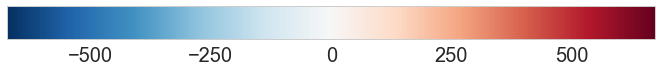

In [627]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=2)
vmax = max(np.abs([data.min() for data in data_res]+[data.max() for data in data_res]))

rdbu = plt.get_cmap('RdBu_r')
norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax)

#fig_res_vcbar = plt.figure(figsize=(10, 8))
#ax1 = fig_res_vcbar.add_axes([0.05, 0.05, 0.05, 0.9])
#mpl.colorbar.ColorbarBase(ax1, cmap=rdbu,norm=norm,orientation='vertical', ticks=[-500, -250, 0, 250, 500])

fig_res_hcbar = plt.figure(figsize=(10, 3))
ax1 = fig_res_hcbar.add_axes([0.05, 0.80, 0.9, 0.15])
mpl.colorbar.ColorbarBase(ax1, cmap=rdbu,norm=norm,orientation='horizontal', ticks=[-500, -250, 0, 250, 500])

## Random examples

In [569]:

random_data_file = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/random/%s/%s_random_%s_t1avg_by_fc_maps_%s.pkl'
i = 66
smooth = 'smooth_24'
hemi = 'lh'
vmin = 1700 
vmax = 2300 


random_data_0 = load_pickle(random_data_file%(smooth, hemi, i, '0'))
#random_data_best = load_pickle(random_data_file%(smooth, hemi, i, 'best'))
random_data_all = load_pickle(random_data_file%(smooth, hemi, i, 'all'))


sns.set_style('white')
cropped_random_lh = []
for data in [random_data_0['t1'], random_data_0['modelled_fit'], 
             random_data_all['modelled_fit']]:
    for (elev, azim) in [(180, 0), (180, 180)]:
        plot=plot_surf_stat_map(lv, lf, stat_map=data, bg_map=lh_sulc, bg_on_stat=True, darkness=0.5, 
                            elev=elev,azim=azim, figsize=(10,7.5) ,threshold=vmin, cmap='cubehelix', 
                            vmin=vmin, vmax=vmax, symmetric_cbar=False)
        cropped_random_lh.append(crop_img(plot))
        
hemi = 'rh'
random_data_0 = load_pickle(random_data_file%(smooth, hemi, i, '0'))
#random_data_best = load_pickle(random_data_file%(smooth, hemi, i, 'best'))
random_data_all = load_pickle(random_data_file%(smooth, hemi, i, 'all'))

sns.set_style('white')
cropped_random_rh = []
for data in [random_data_0['t1'], random_data_0['modelled_fit'], 
             random_data_all['modelled_fit']]:
    for (elev, azim) in [(180, 0), (180, 180)]:
        plot=plot_surf_stat_map(rv, rf, stat_map=data, bg_map=rh_sulc, bg_on_stat=True, darkness=0.5, 
                            elev=elev,azim=azim, figsize=(10,7.5) ,threshold=vmin, cmap='cubehelix',
                            vmin=vmin, vmax=vmax, symmetric_cbar=False)
        cropped_random_rh.append(crop_img(plot))
        
cropped_random = []
for img in range(int(len(cropped_random_lh)/2)):
    cropped_random.append(cropped_random_lh[2*img])
    cropped_random.append(cropped_random_lh[2*img+1])
    cropped_random.append(cropped_random_rh[2*img])
    cropped_random.append(cropped_random_rh[2*img+1])